# EDA & Baseline Modeling

**Goals**  
1. Inspect raw data (`data/raw_posts.csv`)  
2. Visualize text lengths & label distribution  
3. Tweak cleaning rules  
4. Prototype TF-IDF → LogisticRegression pipeline  


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import nltk
nltk.download("vader_lexicon")

# Optional: make plots appear inline
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/NathanB/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# Adjust path if needed
df = pd.read_csv("../data/raw_posts.csv")
print("Rows, Columns:", df.shape)
df.head()


Rows, Columns: (400, 3)


,id,created_utc,text
0,1klqw0x,1.747155e+09,President Zelensky insists on swift meeting wi...
1,1klqque,1.747155e+09,US issues travel warning for South American co...
2,1klqnt9,1.747154e+09,Ukraine Reveals S-200 System Linked to Downed ...
3,1klqjkz,1.747154e+09,Trump says will remove US sanctions on Syria
4,1klqihm,1.747154e+09,Trump secures $600 billion Saudi investment pl...


In [17]:
df.info()      # dtype, non-null counts
df.describe()  # numeric summaries (e.g. created_utc)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           400 non-null    object 
 1   created_utc  400 non-null    float64
 2   text         400 non-null    object 
dtypes: float64(1), object(2)
memory usage: 9.5+ KB


,created_utc
count,4.000000e+02
mean,1.746940e+09
std,1.462121e+05
min,1.746706e+09
25%,1.746804e+09
50%,1.746945e+09
75%,1.747068e+09
max,1.747155e+09


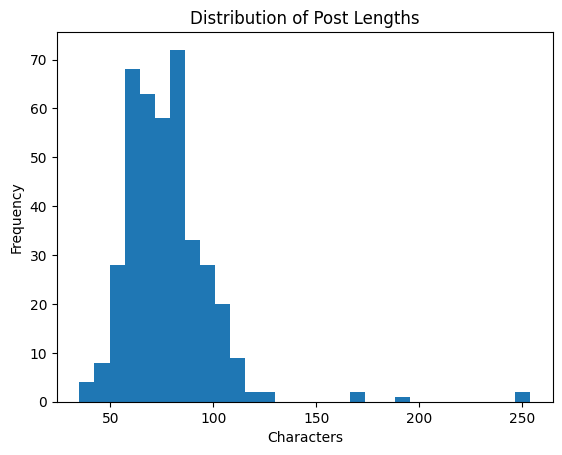

In [18]:
# Compute length of each post
df["length"] = df["text"].str.len()

# Quick histogram
df["length"].plot.hist(bins=30)
plt.title("Distribution of Post Lengths")
plt.xlabel("Characters")
plt.show()


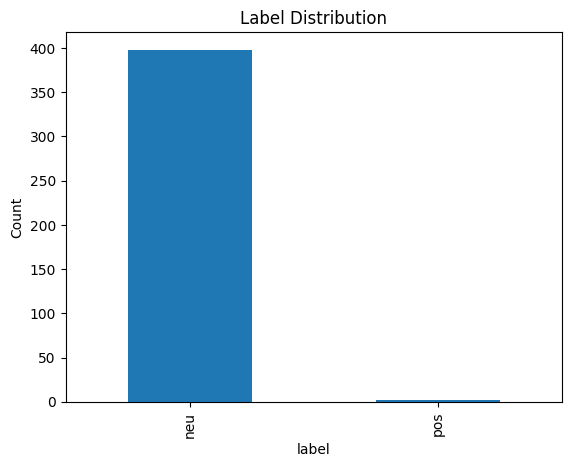

In [19]:
# Reproduce the same hack from your script:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)               # remove URLs
    text = re.sub(r"@\w+", "", text)                  # remove mentions
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)      # keep only letters/numbers
    return text.lower().strip()

df["cleaned"] = df["text"].fillna("").apply(clean_text)
df["label"]   = df["cleaned"].apply(
    lambda t: 1 if "good" in t else (0 if "bad" in t else 2)
)

# Show how many of each
df["label"].map({0:"neg", 1:"pos", 2:"neu"}).value_counts().plot.bar()
plt.title("Label Distribution")
plt.ylabel("Count")
plt.show()


In [20]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned"], df["label"],
    test_size=0.2, random_state=42
)

# Vectorize & train
vect  = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
Xtr   = vect.fit_transform(X_train)
Xte   = vect.transform(X_test)

model = LogisticRegression(max_iter=200)
model.fit(Xtr, y_train)

# Evaluate
y_pred = model.predict(Xte)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.99      1.00      0.99        79

    accuracy                           0.99        80
   macro avg       0.49      0.50      0.50        80
weighted avg       0.98      0.99      0.98        80



In [21]:
# 1) Unigrams only
vect1 = TfidfVectorizer(ngram_range=(1,1), max_features=3000)
Xtr1  = vect1.fit_transform(X_train)
Xte1  = vect1.transform(X_test)

model1 = LogisticRegression(max_iter=200)
model1.fit(Xtr1, y_train)
print("Unigrams only:")
print(classification_report(y_test, model1.predict(Xte1), zero_division=0))

# 2) Bigger vocab (1–2grams, 10k features)
vect2 = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
Xtr2  = vect2.fit_transform(X_train)
Xte2  = vect2.transform(X_test)

model2 = LogisticRegression(max_iter=200)
model2.fit(Xtr2, y_train)
print("2-grams, 10k features:")
print(classification_report(y_test, model2.predict(Xte2), zero_division=0))


Unigrams only:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.99      1.00      0.99        79

    accuracy                           0.99        80
   macro avg       0.49      0.50      0.50        80
weighted avg       0.98      0.99      0.98        80

2-grams, 10k features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.99      1.00      0.99        79

    accuracy                           0.99        80
   macro avg       0.49      0.50      0.50        80
weighted avg       0.98      0.99      0.98        80

